In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] =  '-1'
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd
import gsd.hoomd
import pickle
import matplotlib.pyplot as plt

In [2]:
# building a HTF model for coarse graining
fname = '100-length-4-peek-para-only.gsd'
gsdfile = gsd.hoomd.open(fname)
context = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename=fname)
context.sorter.disable()
set_rcut = 10.

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 01/11/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 88 particles


In [3]:
molecule_mapping_index = htf.find_molecules(system)

Finding molecules...0.00%


typeid       : 2
a            : 1
b            : 87
type         : ca-ca

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]]
oh 0
ca 1
ca 2
ca 3
ca 4
os 5
ca 6
ca 7
ca 8
ca 9
c 10
o 11
ca 12
ca 13
ca 14
os 15
ca 16
ca 17
ca 18
ca 19
os 20
ca 21
ca 22
ca 23
ca 24
c 25
o 26
ca 27
ca 28
ca 29
os 30
ca 31
ca 32
ca 33
ca 34
os 35
ca 36
ca 37
ca 38
ca 39
c 40
o 41
ca 42
ca 43
ca 44
os 45
ca 46
ca 47
ca 48
ca 49
os 50
ca 51
ca 52
ca 53
ca 54
c 55
o 56
ca 57
ca 58
ca 59
ca 60
ca 61
ca 62
ca 63
ca 64
ca 65
ca 66
ca 67
ca 68
ca 69
ca 70
ca 71
ca 72
ca 73
ca 74
ca 75
ca 76
ca 77
ca 78
ca 79
ca 80
ca 81
ca 82
ca 83
ca 84
ca 85
ca 86
ca 87
{'ca': 72, 'oh': 1, 'c': 4, 'o': 4, 'os': 7}
1 0
1 87
2 1
3 2
4 86
4 3


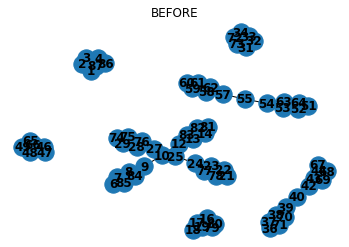

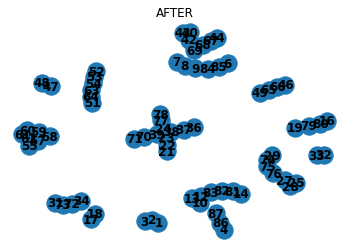

In [5]:
# the OH hydrogen at the beginning(?)
print(system.bonds[1])
print(molecule_mapping_index)
graph = nx.Graph()

unsorted_particles = []
unsorted_bonds = []
type_counts = {'ca': 0, 'oh': 0, 'c': 0, 'o': 0, 'os': 0}
# make a networkx graph with disconnected subgraphs of just ca-type carbons
for i, particle in enumerate(system.particles):
    if particle.type == 'ca':
        graph.add_node(i)
    else:
        unsorted_particles.append(i)
    type_counts[particle.type] += 1
    print(particle.type, i)
    
print(type_counts)
    
for bond in system.bonds:
    if 'o' not in bond.type:
        graph.add_edge(bond.a, bond.b)
    else:
        unsorted_bonds.append((bond.a, bond.b))
    print(bond.a, bond.b)
    
        
print('unsorted particles:', unsorted_particles)
print('unsorted bonds:', unsorted_bonds)
        
print('graph edges:', graph.edges)
print(list(nx.connected_components(graph)))
plt.figure()
plt.title('BEFORE')
nx.draw(graph, with_labels=True, font_weight='bold')

# almost there. need to put the bridging ketone carbons into one bead
# and split those big groups into two
print(len(unsorted_bonds))
for i, bond in enumerate(unsorted_bonds):
    if 'o' in list(system.particles)[bond[0]].type:
        c_idx = bond[1]
    elif 'o' in list(system.particles)[bond[1]].type:
        c_idx = bond[0]
    print(c_idx)
    for graph_bond in graph.edges:
        if c_idx in graph_bond:
            graph.remove_edge(graph_bond[0], graph_bond[1])
            break


plt.figure()
plt.title('AFTER')
nx.draw(graph, with_labels=True, font_weight='bold')
# then for each ignored O, just put it in the first atom it's bonded to
# and don't forget the ignored C's

In [21]:
[system.particles[i].type for i in unsorted_particles]

['oh',
 'os',
 'c',
 'o',
 'os',
 'os',
 'c',
 'o',
 'os',
 'os',
 'c',
 'o',
 'os',
 'os',
 'c',
 'o']

In [9]:
# get total N atoms
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)

N_atoms: 13800 
N_molecules: 100 
N_atoms_per_molecule: 138


In [16]:
# create a mapping for our molecules
# these are 100 4-monomer polymers, so let's try a 4-bead mapping
# therefore, we need a 4 x 138 matrix
# rough estimate for 4-bead mapping TODO: check this
mapping_arr = np.zeros((4,138))

mapping_arr[0][:35]+=1
mapping_arr[1][36:71]+=1
mapping_arr[2][71:105]+=1
mapping_arr[3][105:]+=1

bead_number = mapping_arr.shape[0]

cg_mapping = htf.sparse_mapping([mapping_arr for _ in molecule_mapping_index],
                               molecule_mapping_index, system=system)
assert cg_mapping.shape == (M * bead_number, N)

In [17]:
class MappingModel(htf.SimModel):
    def setup(self, CG_NN, cg_mpaping, rcut):
        pass